In [1]:
!pip install GraphRicciCurvature
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 27.0 MB/s 
     |████████████████████████████████| 5.7 MB 53.3 MB/s 
  Created wheel for networkit: filename=networkit-10.0-cp37-cp37m-linux_x86_64.whl size=8166550 sha256=6572a77b106b4c7114e8f0965f50f302fdaffc2588303b775e08c7d33ba8c27d
  Stored in directory: /root/.cache/pip/wheels/63/7a/29/82ad675434206a11470c7179c78d3f172ea2a6bc05cfb7391c
Successfully built networkit
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from datetime import datetime,timedelta
import networkx as nx
import math
# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci

# load python-louvain for modularity computation
# import community as community_louvain
from community import community_louvain
# for ARI computation
from sklearn import preprocessing, metrics
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from networkx.utils.misc import edges_equal
from networkx.readwrite import edgelist
def howmany_cluster(clustering,good_cut):
    good_idx = np.where(clustering == good_cut)[0][0]
    good_cluster = clustering[good_idx][1]
    howmany = len(set(clustering[good_idx][1].values()))
    for i in range(howmany-1):
        globals()[f'clu_{i}'] = [] 
        for node,qqq in good_cluster.items():
            if qqq == i: 
                globals()[f'clu_{i}'].append(node)

def draw_graph(G):
    pos = nx.spring_layout(G)
    # colors = nx.get_node_attributes(G,'color').values()
    colors = [node[1]['color'] for node in G.nodes(data=True)]
    sizes  = [node[1]['size'] for node in G.nodes(data=True)]

    # nx.draw_networkx_nodes(G, pos,colors=colors)
    # nx.draw_networkx_labels(G, pos)
    # nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw(G, node_color=colors, node_size=sizes, with_labels=True)
def draw_ricci_graph(G):
    """
    A helper function to draw a nx graph with community.
    """
    edgevmin = -0.2; edgevmax = 0.5
    edge_cmap = plt.cm.seismic
    labels = [node[1]['month'] for node in G.nodes(data=True)]
    colors = [node[1]['color'] for node in G.nodes(data=True)]
    sizes  = [node[1]['size'] for node in G.nodes(data=True)]
    curavature = [edge[2]['ricciCurvature'] for edge in G.edges(data=True)]
    # weight = [edge[2]['weight'] for edge in G.edges(data=True)]
    le = preprocessing.LabelEncoder()
    
    nx.draw_spring(G, nodelist=G.nodes(),
                   node_color=colors, node_size=sizes, edgelist=G.edges(),
                   edge_color=curavature, width=2, edge_cmap=edge_cmap,
                   edge_vmin=edgevmin, edge_vmax=edgevmax,style='solid',
                   connectionstyle='arc3,rad=0.05',
                   cmap=plt.cm.rainbow,
                   alpha=0.5 )
    sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin = edgevmin, vmax=edgevmax))
    plt.colorbar(sm)
    plt.show()

def check_accuracy(G_origin, weight="weight", clustering_label="value", plot_cut=True):
    """To check the clustering quality while cut the edges with weight using different threshold

    Parameters
    ----------
    G_origin : NetworkX graph
        A graph with ``weight`` as Ricci flow metric to cut.
    weight: float
        The edge weight used as Ricci flow metric. (Default value = "weight")
    clustering_label : str
        Node attribute name for ground truth.
    plot_cut: bool
        To plot the good guessed cut or not.

    """
    G = G_origin.copy()
    modularity, ari = [], []
    maxw = max(nx.get_edge_attributes(G, weight).values())
    cutoff_range = np.arange(maxw, 1, -0.025)
    allcluster=[]
    for cutoff in cutoff_range:
        edge_trim_list = []
        for n1, n2 in G.edges():
            if G[n1][n2][weight] > cutoff:
                edge_trim_list.append((n1, n2))
        G.remove_edges_from(edge_trim_list)

        # Get connected component after cut as clustering
        clustering = {c: idx for idx, comp in enumerate(nx.connected_components(G)) for c in comp}
        allcluster.append([cutoff,clustering])
        # Compute modularity and ari
        modularity.append(community_louvain.modularity(clustering, G, weight))
        ari.append(ARI(G, clustering, clustering_label=clustering_label))

    plt.xlim(maxw, 0)
    plt.xlabel("Edge weight cutoff")
    plt.plot(cutoff_range, modularity, alpha=0.8)
    plt.plot(cutoff_range, ari, alpha=0.8)
    

    if plot_cut:
        good_cut = -1
        mod_last = modularity[-1]
        drop_threshold = 0.01  # at least drop this much to considered as a drop for good_cut

        # check drop from 1 -> maxw
        for i in range(len(modularity) - 1, 0, -1):
            mod_now = modularity[i]
            if mod_last > mod_now > 1e-4 and abs(mod_last - mod_now) / mod_last > drop_threshold:
                if good_cut != -1:
                    print("Other cut:%f, diff:%f, mod_now:%f, mod_last:%f, ari:%f" % (
                        cutoff_range[i + 1], mod_last - mod_now, mod_now, mod_last, ari[i + 1]))
                else:
                    good_cut = cutoff_range[i + 1]
                    print("*Good Cut:%f, diff:%f, mod_now:%f, mod_last:%f, ari:%f" % (
                        good_cut, mod_last - mod_now, mod_now, mod_last, ari[i + 1]))
            mod_last = mod_now

        plt.axvline(x=good_cut, color="red")
        print('='*60)
        print( f'Good cut at {good_cut}')
        plt.legend(['Modularity', 'Adjust Rand Index', 'Good cut'])
    else:
        plt.legend(['Modularity', 'Adjust Rand Index'])
    return allcluster, good_cut

In [4]:

def show_results(G):
    # Print the first five results
    print("Karate Club Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ollivier-Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2]["ricciCurvature"]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, "ricciCurvature").values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights")

    plt.tight_layout()
def ARI(G, clustering, clustering_label="club"):
    """
    Computer the Adjust Rand Index (clustering accuracy) of "clustering" with "clustering_label" as ground truth.

    Parameters
    ----------
    G : NetworkX graph
        A given NetworkX graph with node attribute "clustering_label" as ground truth.
    clustering : dict or list or list of set
        Predicted community clustering.
    clustering_label : str
        Node attribute name for ground truth.

    Returns
    -------
    ari : float
        Adjust Rand Index for predicted community.        ##這個值的高低代表什麼意思？
    """

    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    y_true = le.fit_transform(list(complex_list.values()))

    if isinstance(clustering, dict):
        # python-louvain partition format
        y_pred = np.array([clustering[v] for v in complex_list.keys()])
    elif isinstance(clustering[0], set):
        # networkx partition format
        predict_dict = {c: idx for idx, comp in enumerate(clustering) for c in comp}
        y_pred = np.array([predict_dict[v] for v in complex_list.keys()])
    elif isinstance(clustering, list):
        # sklearn partition format
        y_pred = clustering
    else:
        return -1

    return metrics.adjusted_rand_score(y_true, y_pred)



def my_surgery(G_origin, weight="weight", cut=0):
    """A simple surgery function that remove the edges with weight above a threshold

    Parameters
    ----------
    G_origin : NetworkX graph
        A graph with ``weight`` as Ricci flow metric to cut.
    weight: str
        The edge weight used as Ricci flow metric. (Default value = "weight")
    cut: float
        Manually assigned cutoff point.

    Returns
    -------
    G : NetworkX graph
        A graph after surgery.
    """
    G = G_origin.copy()
    w = nx.get_edge_attributes(G, weight)

    assert cut >= 0, "Cut value should be greater than 0."
    if not cut:
        cut = (max(w.values()) - 1.0) * 0.6 + 1.0  # Guess a cut point as default

    to_cut = []
    for n1, n2 in G.edges():
        if G[n1][n2][weight] > cut:
            to_cut.append((n1, n2))
    print("*************** Surgery time ****************")
    print("* Cut %d edges." % len(to_cut))
    G.remove_edges_from(to_cut)
    print("* Number of nodes now: %d" % G.number_of_nodes())
    print("* Number of edges now: %d" % G.number_of_edges())
    cc = list(nx.connected_components(G))
    print("* Modularity now: %f " % nx.algorithms.community.quality.modularity(G, cc))    ##這個值的高低代表什麼意思？
    print("* ARI now: %f " % ARI(G, cc))
    print("*********************************************")

    return G


In [5]:
G = nx.read_gpickle("/content/drive/MyDrive/Final_project/Gtest7.gpickle")

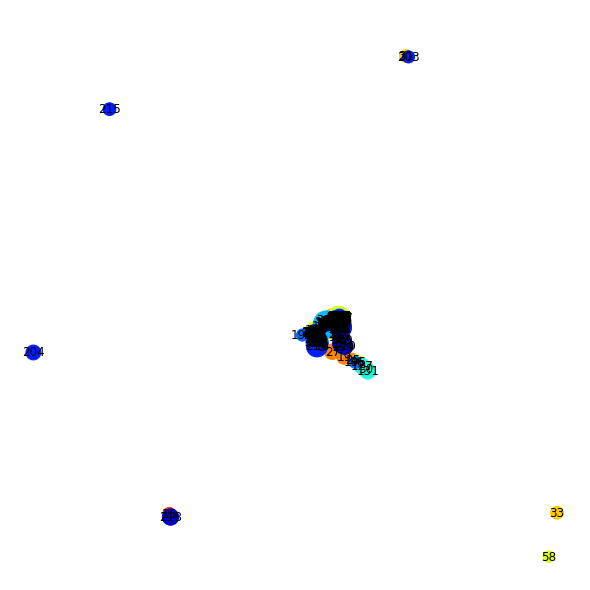

In [6]:
plt.figure(figsize=(8,8))
draw_graph(G)

In [8]:
# Start a Ricci flow with Lin-Yau's probability distribution setting with 4 process.
G_copy = G.copy()
orf = OllivierRicci(G_copy,alpha=0.5, base=math.e , exp_power=2, verbose="INFO") #,shortest_path='pairwise'

orf.set_verbose("ERROR") # mute logs
orf.compute_ricci_flow(iterations=10) 
G_rf = orf.G.copy()

Karate Club Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (0,4) is 0.000000
Ollivier-Ricci curvature of edge (0,10) is 0.571376
Ollivier-Ricci curvature of edge (0,17) is 0.571366
Ollivier-Ricci curvature of edge (0,23) is 0.003904
Ollivier-Ricci curvature of edge (0,37) is 0.000571


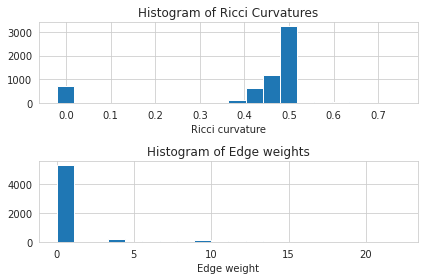

In [9]:
show_results(G_rf)

*Good Cut:4.328649, diff:0.054748, mod_now:0.688144, mod_last:0.742892, ari:0.314077
Other cut:4.353649, diff:0.214046, mod_now:0.474098, mod_last:0.688144, ari:0.314077
Other cut:4.378649, diff:0.025083, mod_now:0.449015, mod_last:0.474098, ari:0.314077
Other cut:4.403649, diff:0.071274, mod_now:0.377741, mod_last:0.449015, ari:0.314077
Other cut:7.953649, diff:0.016859, mod_now:0.695862, mod_last:0.712721, ari:0.284172
Other cut:7.978649, diff:0.011990, mod_now:0.683872, mod_last:0.695862, ari:0.284172
Other cut:8.003649, diff:0.010745, mod_now:0.673127, mod_last:0.683872, ari:0.284172
Other cut:8.028649, diff:0.008077, mod_now:0.665050, mod_last:0.673127, ari:0.284172
Other cut:8.678649, diff:0.009822, mod_now:0.655228, mod_last:0.665050, ari:0.284172
Other cut:9.178649, diff:0.204986, mod_now:0.463778, mod_last:0.668764, ari:0.273869
Other cut:9.203649, diff:0.005050, mod_now:0.458728, mod_last:0.463778, ari:0.230747
Other cut:9.403649, diff:0.006021, mod_now:0.456485, mod_last:0.4

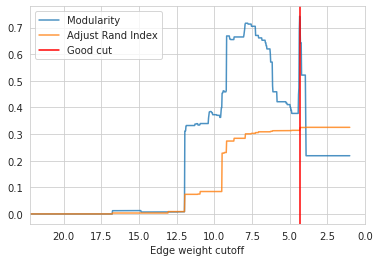

In [11]:
clustering,good_cut = check_accuracy(G_rf, clustering_label="month",plot_cut=True)
howmany_cluster(clustering,good_cut)

*************** Surgery time ****************
* Cut 672 edges.
* Number of nodes now: 221
* Number of edges now: 5347
* Modularity now: 0.742892 
* ARI now: 1.000000 
*********************************************


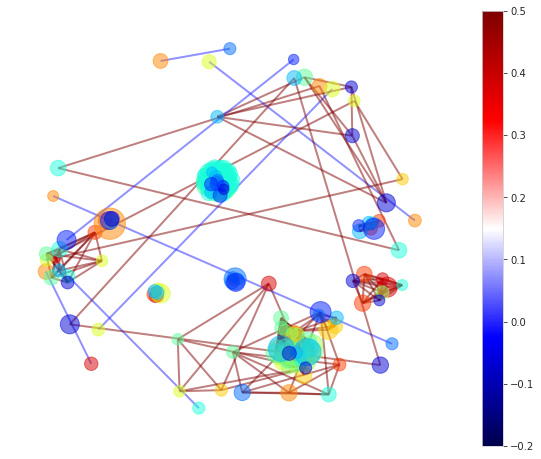

In [12]:
plt.figure(figsize=(10,8))
plt.subplot(111)
draw_ricci_graph(my_surgery(G_rf, cut=good_cut))


### another way to find cluster but you need to cut! 

In [ ]:

G_cut = my_surgery(G_rf, cut=good_cut)
for idx, comp in enumerate(nx.connected_components(G_cut)):
    print(idx,comp)


*************** Surgery time ****************
* Cut 2370 edges.
* Number of nodes now: 229
* Number of edges now: 3651
* Modularity now: 0.307337 
* ARI now: 1.000000 
*********************************************
0 {0, 193, 227, 4, 228, 37, 38, 10, 174, 17, 23, 184}
1 {1}
2 {2, 35, 49, 50, 186}
3 {34, 3, 83, 57, 219}
4 {5}
5 {6, 7}
6 {8, 22, 24, 26, 159, 32, 170, 44, 45, 182, 183, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 194, 81, 87, 88, 89, 90, 91, 92, 225}
7 {9, 202}
8 {11, 171, 109, 82, 223}
9 {198, 199, 12, 205, 176, 177, 213, 214, 188, 189}
10 {195, 13, 79, 175, 212}
11 {14, 29, 42, 48, 51, 53, 54, 55, 56, 84, 85, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167,

In [ ]:
nx.write_gpickle(G_cut,'/content/drive/MyDrive/Final_project/Gtest7_goodcut_cut3.gpickle')